# A/B Testing from Scratch: Multi-armed Bandits

Frequentist and Bayesian A/B tests require you to divide your traffic into arbitrary groups for a period of time, then perform statistical tests based on the results. By definition, this forces us to divert out traffic to suboptimal variations during the test period, resulting in lower overall conversion rates. On the other hand, multi-barmed bandit appraoch (MAB) dynamically adjusts the percentage of traffic shown to each variation according to how they have performed so far during the test, resulting in smaller loss in conversion rates.

![Traditional A/B Test vs Multi-armed Bandits](../images/ab_vs_mab.png)

Source: [Automizy](https://automizy.com/blog/increase-email-course-open-rates-with-machine-learning/) via [Multi-Arm Bandits: a potential alternative to A/B tests](https://medium.com/brillio-data-science/multi-arm-bandits-a-potential-alternative-to-a-b-tests-a647d9bf2a7e)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/AI-COE/ABTest/abtestoo-master

/content/drive/MyDrive/Colab Notebooks/AI-COE/ABTest/abtestoo-master


In [ ]:
import numpy as np
import pandas as pd

#widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

#plots
import matplotlib.pyplot as plt
from plotnine import *

#stats
import scipy as sp
import statsmodels as sm

import warnings
warnings.filterwarnings('ignore')

## Arms, Variations, Ads, or Anything

We treat serving a variation of content, be it product listings, recommended products, search results, online ads, or whatever we want to experiment on as *pulling an arm*. The arm will record an impression and, at an arbitrary amount of delay time, an action such as a click or add-to-cart based on that impression. In our example, we define our arm as a Bernoulli trial with the true probability of conversion ($\frac{actions}{impressions}$) `true_p`.

In [ ]:
class Arm:
    def __init__(self, true_p):
        self.true_p = true_p
        self.reset()
    def reset(self):
        self.impressions = 0
        self.actions = 0
    def get_state(self):
        return self.impressions,self.actions
    def get_rate(self):
        return self.actions / self.impressions if self.impressions >0 else 0.
    def pull(self):
        self.impressions+=1
        res = 1 if np.random.random() < self.true_p else 0
        self.actions+=res
        return res

In [ ]:
# a = Arm(0.5)
# for i in range(100):
#     print(a.pull())

In [ ]:
# a

## Environment

We simulate an environment is an arbitrary number of arms with a set of predefined true probability `true_p` and average number of impressions `avg_impression` per time period `t`. This environment mimics most content serving APIs which display each variation at the ratio `ps` as defined by experimenters.

In [ ]:
class BanditAgent:
    def __init__(self):
        pass
    #thompsons
    def thompson_one(self,state):
        res = [np.random.beta(i[1]+1,i[0]-i[1]+1) for i in state]
        res = np.array(res)
        #print('Thompson_one : ',res)
        return res
    def thompson_stochastic(self,state,n=5):
        l = []
        for i in range(n): l.append(self.thompson_one(state)[None,:])
        #print('First : ', l)
        l = np.concatenate(l,0)
        #print('Later : ', l)
        #print('Mid : ',l.max(1)[:,None])
        is_max = l.max(1)[:,None] == l
        #print('Max : ', is_max )
        #print('Mean : ', is_max.mean(0) )
        return is_max.mean(0)

In [ ]:
class MusketeerEnv:
      def __init__(self, true_ps, avg_impressions):
          self.true_ps = true_ps
          self.avg_impressions = avg_impressions
          self.nb_arms = len(true_ps)
          self.vr_agent = BanditAgent()
          self.reset()
      def reset(self):
          self.t = -1
          self.ds=[]
          self.arms = [Arm(p) for p in self.true_ps]
          return self.get_state()
      def get_state(self):
          return [self.arms[i].get_state() for i in range(self.nb_arms)]
      def get_rates(self):
          return [self.arms[i].get_rate() for i in range(self.nb_arms)]
      def get_impressions(self):
          return int(np.random.triangular(self.avg_impressions-200,
                                      self.avg_impressions,
                                      self.avg_impressions+200))
      def step(self, ps):
          self.t+=1
          impressions = self.get_impressions()
          for i in np.random.choice(a=self.nb_arms,size=impressions,p=ps):
              self.arms[i].pull()
          self.record()
          return self.get_state()

      #use agent to calculate value remaining
      def proportion_test_b(self,n=1000,q=95):

          state = self.get_state()
          best_idx = np.argmax(self.vr_agent.thompson_stochastic(state))
          l=[]
          for i in range(n): l.append(self.vr_agent.thompson_one(state)[None,:])
          l = np.concatenate(l,0)
          p1 = l[:,0]
          p2 = l[:,1]
          return (p1 > p2).mean()

      def proportion_ratio(self,n=1000,q=95):

          state = self.get_state()
          best_idx = np.argmax(self.vr_agent.thompson_stochastic(state))
          l=[]
          for i in range(n): l.append(self.vr_agent.thompson_one(state)[None,:])
          l = np.concatenate(l,0)
          p1 = l[:,0]
          p2 = l[:,1]
          return p1/p2

      def proportion_ci_b(self,n=1000,q=95,p_value=0.05):

          """state = self.get_state()
          best_idx = np.argmax(self.vr_agent.thompson_stochastic(state))
          l=[]
          for i in range(n): l.append(self.vr_agent.thompson_one(state)[None,:])
          l = np.concatenate(l,0)"""
          ratios = proportion_ratio(self,n=1000,q=95)
          return np.quantile(ratios,[p_value/2,1-p_value/2])

      def lift_percent(self,n=10000,q=10,p_value=0.05):

          state = self.get_state()
          best_idx = np.argmax(self.vr_agent.thompson_stochastic(state))
          l=[]
          for i in range(n): l.append(self.vr_agent.thompson_one(state)[None,:])
          l = np.concatenate(l,0)
          p1 = l[:,0]
          p2 = l[:,1]
          lift_percentage = (p2 - p1) / p1
          #print(f"Probability that we are seeing a 2% lift: {np.mean((100 * lift_percentage) > 2) * 100}%")
          return np.mean(lift_percentage),np.percentile(lift_percentage,q)



      def value_remaining(self,n=10000,q=95):
          state = self.get_state()
          best_idx = np.argmax(self.vr_agent.thompson_stochastic(state))
          l=[]
          for i in range(n): l.append(self.vr_agent.thompson_one(state)[None,:])
          #print("l : ", l)
          l = np.concatenate(l,0)

          l_max = l.max(1)
          #print("l_max : ", l_max)
          l_best = l[:,best_idx]
          #print("l_best : ", l_best)
          vs = (l_max - l_best)/l_best
          #print("vs : ", vs)
          return np.percentile(vs,q)

      def record(self):
          d = {'timestep':self.t,'max_rate':0,'opt_clicks':0}
          for i in range(self.nb_arms):
              d[f'clicks_{i}'],d[f'conversion_{i}'] = self.arms[i].get_state()
              d[f'rate_{i}'] = self.arms[i].get_rate()
              if d[f'rate_{i}'] > d['max_rate']:
                  d['max_rate'] = d[f'rate_{i}']
                  d['opt_clicks'] = d[f'clicks_{i}']
          d['total_clicks'] = sum([self.arms[i].impressions for i in range(self.nb_arms)])
          d['opt_clicks_rate'] = d['opt_clicks'] / d['total_clicks']
          d['total_conversion'] = sum([self.arms[i].actions for i in range(self.nb_arms)])
          d['total_rate'] = d['total_conversion'] / d['total_clicks']
          d['regret_rate'] = d['max_rate'] - d['total_rate']
          d['regret'] = d['regret_rate'] * d['total_clicks']
          d['value_remaining'] = self.value_remaining()
          d['Probability_0_over_1'] = self.proportion_test_b()
          d['Average_0_1_ratio'] = self.proportion_ratio().mean()
          d['Lift'],d['Lift_Threshold'] =  self.lift_percent()
          self.ds.append(d)
      def show_df(self):
          df = pd.DataFrame(self.ds)
          result = pd.DataFrame(self.ds)
          cols = ['timestep'] + [f'rate_{i}' for i in range(self.nb_arms)]+ \
                [f'clicks_{i}' for i in range(self.nb_arms)]+ \
                [f'conversion_{i}' for i in range(self.nb_arms)]+ \
                ['total_clicks','total_conversion','total_rate']+ \
                ['opt_clicks','opt_clicks_rate']
          res = ['timestep'] + [f'rate_{i}' for i in range(self.nb_arms)]+ \
                ['total_rate']+ \
                ['regret_rate',"Lift_Threshold",'value_remaining','Probability_0_over_1','Average_0_1_ratio','Lift']
          df = df[cols]
          result = result[res]
          return df,result

In [ ]:
# df

For instance, in a traditional A/B test with a default variation, new variation `A` and new variation `B`. We may divide 60% traffic to the default variation and 20% each to `A` and `B`. After 1,000 time steps, we will get the following results.

In [ ]:
env = MusketeerEnv(true_ps = [.10,.105], avg_impressions=600)
a = BanditAgent()
p = [.50,.50]
value_remaining = 200
while value_remaining > 0.01:
    env.step(p)
    p = a.thompson_stochastic(env.get_state())
    _,result = env.show_df()
    value_remaining = result.value_remaining.tolist()[-1]
    print(result)
    print(value_remaining)
    #env.step(p)
    #t=i
df,result = env.show_df()
#result = env.show_df()

   timestep    rate_0    rate_1  total_rate  regret_rate  Lift_Threshold  \
0         0  0.086053  0.100592    0.093333     0.007258       -0.142574   

   value_remaining  Probability_0_over_1  Average_0_1_ratio      Lift  
0         0.258946                 0.251           0.884671  0.197007  
0.2589463517724673
   timestep    rate_0    rate_1  total_rate  regret_rate  Lift_Threshold  \
0         0  0.086053  0.100592    0.093333     0.007258       -0.142574   
1         1  0.086053  0.104689    0.099681     0.005008       -0.063912   

   value_remaining  Probability_0_over_1  Average_0_1_ratio      Lift  
0         0.258946                 0.251           0.884671  0.197007  
1         0.148207                 0.183           0.849200  0.231144  
0.14820668348090632
   timestep    rate_0    rate_1  total_rate  regret_rate  Lift_Threshold  \
0         0  0.086053  0.100592    0.093333     0.007258       -0.142574   
1         1  0.086053  0.104689    0.099681     0.005008       -0.0

In [ ]:
df.head()

,timestep,rate_0,rate_1,clicks_0,clicks_1,conversion_0,conversion_1,total_clicks,total_conversion,total_rate,opt_clicks,opt_clicks_rate
0,0,0.086053,0.100592,337,338,29,34,675,63,0.093333,338,0.500741
1,1,0.086053,0.104689,337,917,29,96,1254,125,0.099681,917,0.731260
2,2,0.086053,0.100616,337,1461,29,147,1798,176,0.097887,1461,0.812570
3,3,0.090426,0.096739,564,1809,51,175,2373,226,0.095238,1809,0.762326
4,4,0.090647,0.100962,695,2288,63,231,2983,294,0.098558,2288,0.767013


In [ ]:
result.head()

,timestep,rate_0,rate_1,total_rate,regret_rate,Lift_Threshold,value_remaining,Probability_0_over_1,Average_0_1_ratio,Lift
0,0,0.086053,0.100592,0.093333,0.007258,-0.142574,0.258946,0.251,0.884671,0.197007
1,1,0.086053,0.104689,0.099681,0.005008,-0.063912,0.148207,0.183,0.849200,0.231144
2,2,0.086053,0.100616,0.097887,0.002729,-0.094053,0.187237,0.200,0.875124,0.179387
3,3,0.090426,0.096739,0.095238,0.001500,-0.120660,0.196858,0.346,0.950235,0.078261
4,4,0.090647,0.100962,0.098558,0.002403,-0.061991,0.118549,0.236,0.914073,0.121815


In [ ]:
result.to_excel("MABian_output.xlsx")
df.to_excel("MABian_dataset.xlsx")

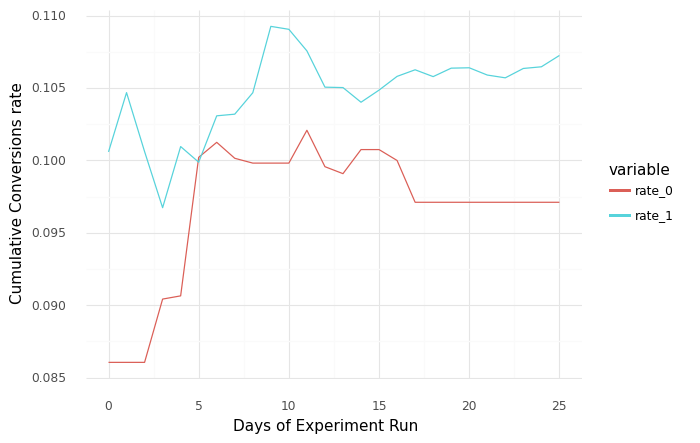

<ggplot: (8791586643188)>

In [ ]:
rates_df = df[['timestep','rate_0','rate_1']].melt(id_vars='timestep')
g = (ggplot(rates_df, aes(x='timestep', y='value', color='variable')) + geom_line() + theme_minimal() +
          xlab('Days of Experiment Run') + ylab('Cumulative Conversions rate'))
g

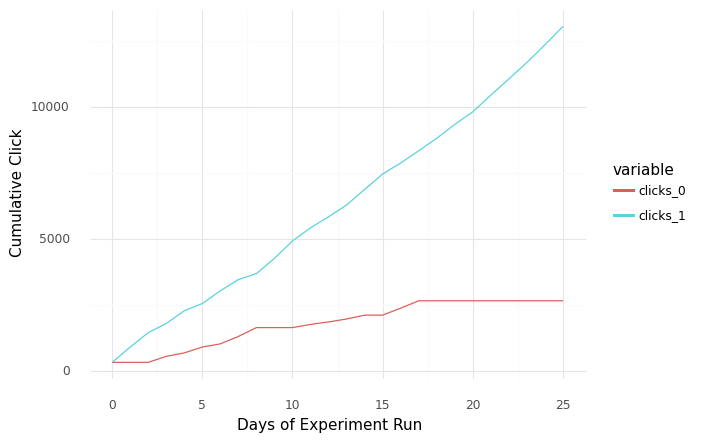

<ggplot: (8791588074487)>

In [ ]:
rates_df = df[['timestep','clicks_0','clicks_1']].melt(id_vars='timestep')
g = (ggplot(rates_df, aes(x='timestep', y='value', color='variable')) + geom_line() + theme_minimal() +
          xlab('Days of Experiment Run') + ylab('Cumulative Click'))
g

In [ ]:
rates_df = df[['timestep','regret_rate']].melt(id_vars='timestep')
g = (ggplot(rates_df, aes(x='timestep', y='value', color='variable')) + geom_line() + theme_minimal() +
          xlab('Days of Experiment Run') + ylab('Regret rate'))
g

KeyError: ignored

In [ ]:
rates_df = df[['timestep','total_rate']].melt(id_vars='timestep')
g = (ggplot(rates_df, aes(x='timestep', y='value', color='variable')) + geom_line() + theme_minimal() +
          xlab('Days of Experiment Run') + ylab('Total Conversion'))
g

In [ ]:
rates_df = df[['timestep','value_remaining']].melt(id_vars='timestep')
g = (ggplot(rates_df, aes(x='timestep', y='value', color='variable')) + geom_line() + theme_minimal() +
          xlab('Days of Experiment Run') + ylab('Value Remaining'))
g

In [ ]:
rates_df = df[['timestep','value_remaining']].melt(id_vars='timestep')
g = (ggplot(rates_df, aes(x='timestep', y='value', color='variable')) + geom_line() + theme_minimal() +
          xlab('Days of Experiment Run') + ylab('Value Remaining'))
g

In [ ]:
df.head()

In [ ]:
rates_df = df[['timestep','Lift']].melt(id_vars='timestep')
g = (ggplot(rates_df, aes(x='timestep', y='value', color='variable')) + geom_line() + theme_minimal() +
          xlab('Days of Experiment Run') + ylab('Lift'))
g

In [ ]:
rates_df = df[['timestep','Average_0_1_ratio']].melt(id_vars='timestep')
g = (ggplot(rates_df, aes(x='timestep', y='value', color='variable')) + geom_line() + theme_minimal() +
          xlab('Days of Experiment Run') + ylab('Average_0_1_ratio'))
g

In [ ]:
#value_remaining
#print(p)

In [ ]:
"""env = MusketeerEnv(true_ps = [0.1,0.12], avg_impressions=400)
for i in range(24):
    env.step([0.6,0.4])
env.show_df()"""

In [ ]:
env.show_df()

In order to evaluate an MAB agent, we use 3 main metrics:
1. `opt_impressions_rate`: cumulative percentage of impressions we have given to the optimal arm at that timestep; this shows us how often we have picked the "best" arm
2. `regret_rate`: cumulative conversion rate of the best arm at that timestep minus cumulative conversion rate of all impressions; this shows us the difference in conversion rate we have lost by not picking the "best" arm
3. `regret`: cumulative actions if we had chosen the "best" arm minus actual cumulative conversions; this shows us how much actions we have lost by not picking the "best" arm

In [ ]:
#env.show_df().head()

## Agent

An MAB agent solves the explore-vs-exploit dilemma. Exploitation means we choose what we know as the best choice at the current timestep, sometimes called being *greedy*; on the other hand, exploration means we try pulling other arms in order to know more about the environment.

Exploiting 100% of the time is a bad idea. For instance; let us assume there are two arms `A` and `B` with true probabilities 0.1 and 0.9 and it happens that when we pull `A` it returns a conversion whereas when we pull `B` it does not. If our policy is to always exploit, we would end up pulling only `A` which has much lower return rate than `B`. This is when you do not have any experiment set up for your content at all.

In contrast, if we always explore, we would end up pulling both arms randomly with expected return rates of $0.9 * 0.5 + 0.1 * 0.5 = 0.5$ instead of much higher if we could find out `B` is the better arm. This is close to what happens in a traditional A/B test during the test period.

Some common policies for distributing impressions to each arm are:
1. **Equal weights**: all arms have the same amount of traffic or a fixed amount.
2. **Randomize**: randomly assign traffic to all arms.
3. **Epsilon-greedy**: Assign a majority of traffic to the "best" arm at that time step, and the rest randomized among all arms; the degree of random traffic can be decayed by a parameter `gamma` as time goes on.
4. **Softmax or Boltzmann exploration**: Assigns traffic equal to the softmax activation of their current return rates; regulated by temperature parameter `tau` (lower `tau` means less exploration) that can also be decayed by `gamma` over time.
$$P(A_i) = \frac{e^{rate_i/\tau}}{\sum{e^{rate_i/\tau}}}$$

5. **Upper Confidence Bound**: by utilizing Hoeffding’s Inequality, we can have a deterministic policy based on number of times the arms are pulled so far and impressions of each arm:

$$A = argmax(rate_i + \sqrt{\frac{2\log{t}}{impressions_i}})$$

6. **Deterministic Thompson Sampling**: based on a posterior distribution (in our case a Beta distribution) for each arm, sample that number of rates. Choose the arm with the highest sampled rate.

7. **Stochastic Thompson Sampling**: Instead of sampling only once, perform a Monte Carlo simulation for an arbitrary number of times, the traffic to each arm is divided by the percentage of times that arm is the best arm in the simulation.

In [ ]:
class BanditAgent:
    def __init__(self):
        pass
    #baselines
    def equal_weights(self,state):
        res = np.array([1/len(state) for i in range(len(state))])
        return res
    def randomize(self,state):
        res = np.random.rand(len(state))
        res /= res.sum()
        return res

    #stochastic policies
    def eps_greedy(self, state, t, start_eps=0.3, end_eps=0.01, gamma=0.99):
        eps = max(end_eps,start_eps * gamma**t)
        res = np.array([eps/len(state) for i in range(len(state))])
        best_idx = np.argmax([i[1]/i[0] for i in state]) if t > 0 else np.random.choice(range(len(state)))
        res[best_idx] += 1-eps
        return res
    def softmax(self, state, t, start_tau=1e-1, end_tau=1e-4, gamma=0.9):
        tau = max(end_tau,start_tau*gamma**t)
        sum_exp = sum([np.exp(i[1]/(i[0]+1e6)/tau) for i in state])
        res = np.array([np.exp(i[1]/(i[0]+1e6)/tau) / sum_exp for i in state])
        return res

    #deterministic policies
    def ucb(self, state, t):
        for i in state:
            if i[0]==0:
                return self.equal_weights(state)
        res = [(i[1]/i[0] + np.sqrt(2*np.log(t+1)/i[0])) for i in state]
        res = np.array(res)
        res_d = np.zeros(len(state))
        res_d[np.argmax(res)] = 1
        return res_d
    def thompson_deterministic(self, state):
        res = [np.random.beta(i[1]+1,i[0]-i[1]+1) for i in state]
        res = np.array(res)
        res_d = np.zeros(len(state))
        res_d[np.argmax(res)] = 1
        return res_d

    #thompsons
    def thompson_one(self,state):
        res = [np.random.beta(i[1]+1,i[0]-i[1]+1) for i in state]
        res = np.array(res)
        return res
    def thompson_stochastic(self,state,n=1000):
        l = []
        for i in range(n): l.append(self.thompson_one(state)[None,:])
        l = np.concatenate(l,0)
        is_max = l.max(1)[:,None] == l
        return is_max.mean(0)

## Stopping Criteria: Value Remaining
Stopping criteria for MAB experiments such as ROPE and expected loss as described in [Bayesian A/B Testing: a step-by-step guide](http://www.claudiobellei.com/2017/11/02/bayesian-AB-testing/); here we are using **value remaining** as introduced by [Google](https://support.google.com/analytics/answer/2846882?hl=en). Value remaining per round of experiment is defined as:

$$V_t = \frac{rate_{max}-rate_{opt}}{rate_{opt}}$$

As experiment goes on, we plot the distribution of $V_t$ and stops when the $1-\alpha$ percentile is lower than our threshold. Intuitively, this is to say that we are $1-\alpha$% confident that our "best" arm might be beaten by the margin equals to the threshold. For practical purpose, we try 95th percentile and threshold of 0.01.

## Simulation Results

We simulate 3 campaigns with true probabilities of 12%, 13% and 14% respectively. Our number of overall impressions is 400 on average.

In [ ]:
env = MusketeerEnv(true_ps = [.12,.13,.14], avg_impressions=400)
a = BanditAgent()
for i in range(60):
    p = a.equal_weights(env.get_state())
    env.step(p)
    t=i
df = env.show_df()
"""a.equal_w
a.equal_weights(env.get_state()),\
a.randomize(env.get_state()),\
 a.eps_greedy(env.get_state(),t),\
a.softmax(env.get_state(),t), \
a.thompson_stochastic(env.get_state()), \
a.ucb(env.get_state(),t), \
a.thompson_deterministic(env.get_state())"""

In [ ]:
df

In [ ]:
"""rates_df = df[['timestep','rate_0','cumu_rate_b']].melt(id_vars='click_day')
g = (ggplot(rates_df, aes(x='click_day', y='value', color='variable')) + geom_line() + theme_minimal() +
          xlab('Days of Experiment Run') + ylab('Cumulative Conversions rate'))
g"""

In [ ]:
"""env = MusketeerEnv(true_ps = [.12,.13], avg_impressions=400)
a = BanditAgent()
for i in range(1):
    p = a.thompson_stochastic(env.get_state())
    env.step(p)
    t=i"""

In [ ]:
"""envs = [MusketeerEnv(true_ps = [0.12,0.13,0.14], avg_impressions=400) for i in range(7)]
a = BanditAgent()
for t in range(200):
    states = [env.get_state() for env in envs]
    actions = [a.equal_weights(states[0]), a.randomize(states[1]),
               a.eps_greedy(states[2],t), a.softmax(states[3],t),
               a.thompson_stochastic(states[4]),
               a.ucb(states[5],t), a.thompson_deterministic(states[6])]
    for i in range(7): envs[i].step(actions[i])
dfs = [env.show_df() for env in envs]
policies = ['equal_weights','randomize','eps_greedy','softmax','thompson_stochastic',
            'ucb','thompson_deterministic']
for i in range(7): dfs[i]['policy'] = policies[i]
df = pd.concat(dfs)[['policy','t','opt_impressions_rate','regret_rate','regret','value_remaining']]"""

In [ ]:
"""df_m = df.melt(id_vars=['policy','t'])
df_m.tail()"""

With our initial agent parameters, we obtain the following results. We can see that stochastic Thompson sampling learns the fastest and is the most stable policy.

In [ ]:
"""g = (ggplot(df_m, aes(x='t',y='value',color='policy',group='policy')) +
    geom_line() + theme_minimal() + facet_wrap('~variable',scales='free_y'))
g"""

## References

Here are some useful resources reviewed for this notebook.

- [tl;dr Bayesian A/B test](https://medium.com/hockey-stick/tl-dr-bayesian-a-b-testing-with-python-c495d375db4d)
- [Bayesian A/B Testing: a step-by-step guide](http://www.claudiobellei.com/2017/11/02/bayesian-AB-testing/)
- [Bayesian Coin Flips](https://www.thomasjpfan.com/2015/09/bayesian-coin-flips/)
- [Multi-Arm Bandits: a potential alternative to A/B tests](https://medium.com/brillio-data-science/multi-arm-bandits-a-potential-alternative-to-a-b-tests-a647d9bf2a7e)
- [Multi Armed Bandits and Exploration Strategies](https://sudeepraja.github.io/Bandits/)
- [MAB Google](https://support.google.com/analytics/answer/2846882?hl=en)